# Clustering con autoencoders

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Ejecutar primero el archivo de lectura_datos.py en caso de que no exista covid_periodos.shp
dir_principal = os.getcwd()
dir_datos = dir_principal+'\\datos'

covid = gpd.read_file(dir_datos+'/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)
covid = covid.loc[pd.IndexSlice[:,'2020-03':],:]
covid = covid.to_crs('POSGAR94')

# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
geo = geo.reset_index(level = 'mes', drop = True)
centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid
centroides = centroides.reset_index(level = 'mes', drop = True)
print("las cordenadas CRS son: "+str(geo.crs))
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]


columnas = ['clasificac', 'fallecido']

# Variables acumuladas a partir del mes que todas tienen al menos 1 

covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 0
valor = True
while valor == True:
    Mes = covid.index.get_level_values(1).unique()[mes]
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,Mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(Mes))
covid_acum['personas'] = covid.personas

covid2 = covid_acum.loc[pd.IndexSlice[:,Mes:],:]
covid_ult_mes = covid_acum.loc[pd.IndexSlice[:,'2021-07'],:]
covid_ult_mes = covid_ult_mes.reset_index(level = 'mes', drop = True)

#casos cada 10 mil habitantes
fallecidos = covid2.fallecido/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)
positivos = covid2.clasificac/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)
falle = covid2.fallecido/(covid2.personas/10000)

# Calculamos el coeficiente de localización
from lq import *
lq_ = lq(covid2,'fallecido','clasificac')
lq_fall_conf = lq_[2]
ind_fall_conf = lq_[0]

#la variable se elige para comparar con diferentes opciones
variable = fallecidos #covid2[['clasificac','personas']]

las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


C:\Users\Pablo\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]


In [3]:
import sklearn.pipeline
import sklearn.preprocessing
import procesos

pipe_coord = sk.pipeline.Pipeline([
    ('periodos', procesos.peri_columna()),
    ('coordenadas', procesos.agrega_centroides(centroides))
])

norm_l1 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
     ('norm_l1', sk.preprocessing.Normalizer('l1'))])
norm_l2 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
    ('norm_l2', sk.preprocessing.Normalizer('l2'))])

pipe = sk.pipeline.Pipeline([
    ('coord', pipe_coord),
    ('norml1', norm_l1)])


In [4]:
X = norm_l2.fit_transform(pipe_coord.fit_transform(fallecidos))
X

array([[ 0.10501657,  0.06491797,  0.03989889, ..., -0.30504769,
         0.8518715 , -0.30988538],
       [-0.13974693, -0.09065396, -0.11885757, ..., -0.377653  ,
         0.76425008, -0.27682394],
       [ 0.175485  ,  0.16144447,  0.1575493 , ..., -0.14007865,
         0.87688178, -0.32242928],
       ...,
       [ 0.07029931,  0.03325526, -0.0181941 , ..., -0.27365896,
        -0.46335219,  0.80165502],
       [ 0.40327886,  0.38115879,  0.37183734, ...,  0.21878833,
        -0.15559577, -0.50531809],
       [ 0.33493252,  0.32738978,  0.32430912, ...,  0.13168887,
        -0.1624785 , -0.70743894]])

In [5]:
X.shape

(525, 9)

In [6]:
entrada = layers.Input(shape = (9,))
encoder = layers.Dense(3, activation = "relu")(entrada)
decoder = layers.Dense(9, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 36        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 347us/sample - loss: -0.3929
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: -0.3953
Epoch 3/50
525/525 [==============================] - 0s 19us/sample - loss: -0.3976
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: -0.3999
Epoch 5/50
525/525 [==============================] - 0s 21us/sample - loss: -0.4022
Epoch 6/50
525/525 [==============================] - 0s 21us/sample - loss: -0.4044
Epoch 7/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4065
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4086
Epoch 9/50
525/525 [==============================] - 0s 21us/sample - loss: -0.4107
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4127
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4147
Epoch 12/50
525/525 [====================

In [8]:
encoded_input = layers.Input(shape = (3,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

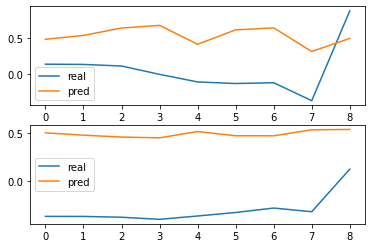

In [10]:
lista = np.random.randint(0,525,2)

fig, ax = plt.subplots(2,1)
j = 0
for i in lista:
    ax[j].plot(X[i], label = 'real')
    ax[j].plot(decoded_valores[i], label = 'pred')
    ax[j].legend()
    j += 1

In [11]:
encoded_valores

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00982097, 0.        , 0.        ],
       ...,
       [0.7553133 , 0.        , 0.56077105],
       [1.2426275 , 0.228493  , 0.17399444],
       [1.1197741 , 0.36223933, 0.        ]], dtype=float32)

In [12]:
import sklearn.cluster as clust 
km = clust.KMeans()
km.fit(encoded_valores)
km.labels_

array([1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 1, 5,
       3, 5, 5, 3, 1, 5, 5, 3, 5, 1, 3, 3, 3, 5, 1, 5, 6, 0, 3, 1, 6, 6,
       3, 1, 3, 1, 6, 3, 5, 5, 3, 3, 3, 1, 6, 6, 3, 1, 1, 3, 1, 5, 1, 1,
       5, 3, 3, 5, 5, 3, 1, 5, 5, 5, 5, 5, 3, 3, 5, 5, 2, 3, 5, 5, 3, 3,
       3, 5, 1, 6, 5, 3, 5, 1, 3, 5, 6, 3, 5, 6, 6, 5, 5, 3, 6, 0, 3, 6,
       3, 3, 1, 6, 1, 5, 3, 1, 1, 5, 3, 1, 3, 5, 4, 3, 1, 5, 5, 5, 5, 5,
       3, 3, 5, 3, 3, 3, 1, 6, 3, 3, 5, 1, 3, 5, 1, 4, 3, 1, 1, 7, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 4, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 2, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5,
       7, 7, 1, 1, 1, 1, 1, 3, 1, 1, 7, 1, 1, 1, 7, 1, 5, 1, 1, 1, 1, 2,
       6, 2, 4, 4, 4, 1, 6, 4, 2, 4, 4, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 0, 5, 5,
       5, 5, 1, 6, 5, 3, 1, 1, 5, 1, 1, 3, 3, 0, 4,

In [13]:
import sklearn.metrics as met 
met.silhouette_score(encoded_valores, km.labels_)

0.6074177

In [14]:
met.silhouette_score(X, km.labels_)

0.15880174126955957

In [149]:
from lq import *
lqcovid = lq_peri(covid2[['clasificac','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.8392857142857143

In [16]:
aglo = clust.AgglomerativeClustering(n_clusters = 30)
aglo.fit(encoded_valores)
met.silhouette_score(encoded_valores, aglo.labels_)

0.6040437

In [17]:
1-lqcovid.calcular_indice_debil(aglo.labels_)

0.8399014778325123

<AxesSubplot:>

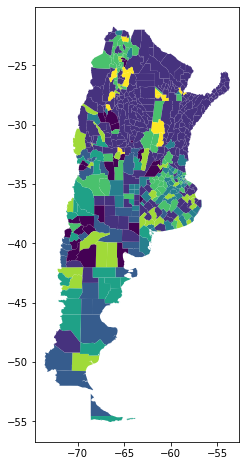

In [18]:
covid_acum_geo = covid_ult_mes.copy()
covid_acum_geo['geometry'] = geo
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8))

<AxesSubplot:>

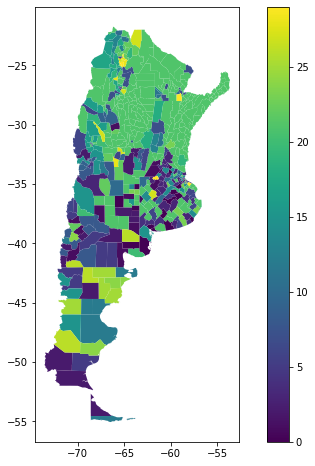

In [19]:
gpd.GeoDataFrame(covid_acum_geo).plot(aglo.labels_, figsize = (10,8), legend = True)

In [ ]:
variable = (covid_acum.fallecido/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)).fillna(0)
X = norm_l2.fit_transform(pipe_coord.fit_transform(variable))
X.shape

In [21]:
entrada = layers.Input(shape = (19,))
encoder = layers.Dense(5, activation = "relu")(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(19, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "mse")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 100       
_________________________________________________________________
dense_3 (Dense)              (None, 19)                114       
Total params: 214
Trainable params: 214
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 286us/sample - loss: 0.3140
Epoch 2/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3134
Epoch 3/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3127
Epoch 4/50
525/525 [==============================] - 0s 15us/sample - loss: 0.3120
Epoch 5/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3114
Epoch 6/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3107
Epoch 7/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3101
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3094
Epoch 9/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3088
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3082
Epoch 11/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3075
Epoch 12/50
525/525 [==============================]

In [23]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

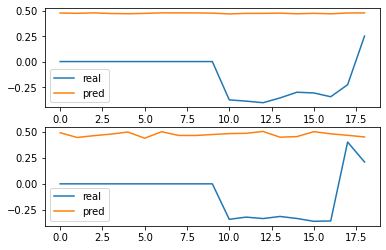

In [24]:
lista = np.random.randint(0,525,2)

fig, ax = plt.subplots(2,1)
j = 0
for i in lista:
    ax[j].plot(X[i], label = 'real')
    ax[j].plot(decoded_valores[i], label = 'pred')
    ax[j].legend()
    j += 1

In [25]:
km.fit(encoded_valores)
met.silhouette_score(encoded_valores, km.labels_)

0.3851934

In [26]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.6165966386554622

In [27]:
met.silhouette_score(X, km.labels_)

0.16704277797710984

In [28]:
from tensorflow.keras import regularizers
peri = procesos.peri_columna()
X = peri.fit_transform(variable)
X = norm_l2.fit_transform(X)
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(17, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 17)                102       
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [29]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 343us/sample - loss: 1.3738
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: 1.2220
Epoch 3/50
525/525 [==============================] - 0s 19us/sample - loss: 1.0737
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: 0.9297
Epoch 5/50
525/525 [==============================] - 0s 21us/sample - loss: 0.7916
Epoch 6/50
525/525 [==============================] - 0s 19us/sample - loss: 0.6632
Epoch 7/50
525/525 [==============================] - 0s 21us/sample - loss: 0.5412
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 0.4263
Epoch 9/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3164
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.2120
Epoch 11/50
525/525 [==============================] - 0s 17us/sample - loss: 0.1091
Epoch 12/50
525/525 [==============================]

In [30]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

In [31]:
cent = procesos.agrega_centroides(centroides)
encoded_valores = cent.fit_transform(encoded_valores)
encoded_valores = norm_l1.fit_transform(encoded_valores)

In [32]:
km.fit(encoded_valores)
met.silhouette_score(encoded_valores, km.labels_)

0.3835677660359886

In [33]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.5220588235294117

<AxesSubplot:>

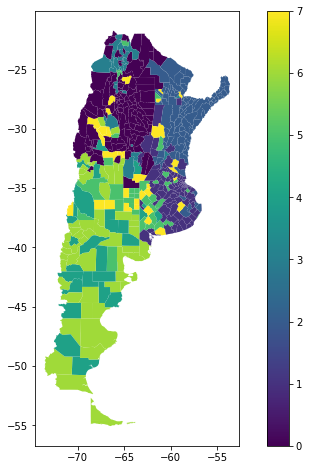

In [34]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [35]:
aglo = clust.AgglomerativeClustering(n_clusters = 15)
aglo.fit(encoded_valores)

AgglomerativeClustering(n_clusters=15)

In [36]:
met.silhouette_score(encoded_valores, aglo.labels_)

0.337037746560682

In [37]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(aglo.labels_)

0.5254901960784313

<AxesSubplot:>

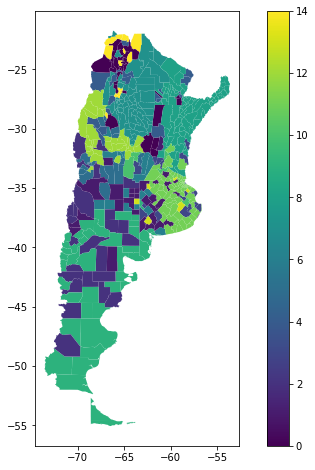

In [38]:
gpd.GeoDataFrame(covid_acum_geo).plot(aglo.labels_, figsize = (10,8), legend = True)

In [39]:
db = clust.DBSCAN(eps = 0.2, min_samples = 10).fit(encoded_valores)

In [40]:
met.silhouette_score(encoded_valores, db.labels_)

0.409463338911689

In [41]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(db.labels_)

0.4901960784313726

<AxesSubplot:>

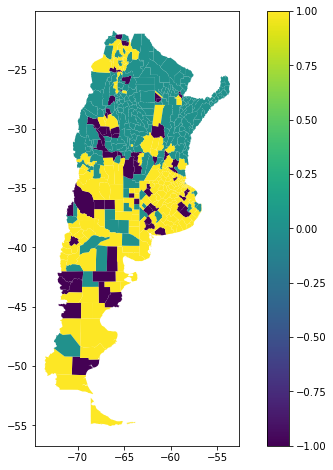

In [42]:
gpd.GeoDataFrame(covid_acum_geo).plot(db.labels_, figsize = (10,8), legend = True)

## positivos y confirmados

In [43]:
datos = covid_acum.apply(lambda x: x/covid_acum.personas*10000)[['clasificac','fallecido']]
X = pipe.fit_transform(datos)
X.shape

(525, 36)

In [44]:
geom = X[:,-2:]
temp = X[:,:-2]
temp

array([[ 0.01019815,  0.02255377,  0.28484866, ..., -0.00269762,
        -0.00582242, -0.00754496],
       [ 0.07559766,  0.02291428,  0.05604072, ..., -0.02123058,
        -0.02908875, -0.03628396],
       [ 0.0487999 ,  0.02010549,  0.06549028, ...,  0.00161269,
        -0.00326928, -0.0066822 ],
       ...,
       [ 0.02392621,  0.00505088, -0.00231598, ..., -0.00580062,
        -0.01395431, -0.01703127],
       [ 0.0056541 ,  0.00464607,  0.00065598, ...,  0.02104742,
         0.01789335,  0.01745624],
       [ 0.1432737 ,  0.09345447,  0.05301385, ...,  0.01337681,
         0.01034025,  0.00910384]])

In [45]:
X = temp
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(X.shape[1], activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 175       
_________________________________________________________________
dense_7 (Dense)              (None, 34)                204       
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [46]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 354us/sample - loss: 2.7220
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: 2.4424
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: 2.1745
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: 1.9165
Epoch 5/50
525/525 [==============================] - 0s 21us/sample - loss: 1.6702
Epoch 6/50
525/525 [==============================] - 0s 21us/sample - loss: 1.4413
Epoch 7/50
525/525 [==============================] - 0s 21us/sample - loss: 1.2270
Epoch 8/50
525/525 [==============================] - 0s 17us/sample - loss: 1.0262
Epoch 9/50
525/525 [==============================] - 0s 19us/sample - loss: 0.8329
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.6554
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: 0.4958
Epoch 12/50
525/525 [==============================]

In [47]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

In [48]:
X = np.c_[encoded_valores,geom]
km.fit(X)

KMeans()

In [49]:
met.silhouette_score(X, km.labels_)

0.42216868241281036

In [112]:
lqcovid_f = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid_f.calcular_indice_debil(km.labels_)

0.5598739495798319

In [51]:
lqcovid_p = lq_peri(covid_acum[['clasificac','personas']])
1-lqcovid_p.calcular_indice_debil(km.labels_)

0.7636554621848739

In [52]:
aglo.fit(X)
met.silhouette_score(X, aglo.labels_)

0.38016154526996526

In [53]:
lqcovid_f.calcular_indice_debil(aglo.labels_)

0.49411764705882344

In [54]:
lqcovid_p.calcular_indice_debil(aglo.labels_)

0.20784313725490194

<AxesSubplot:>

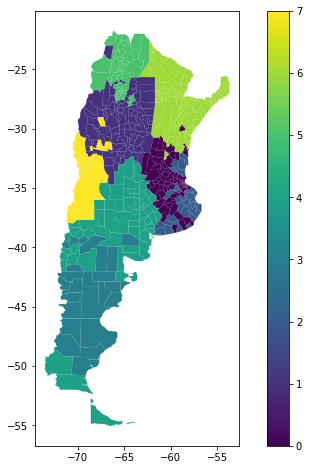

In [55]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [98]:
#def tabla_rdos(datos,model)
model = km
datos_rdos = peri.fit_transform(datos)
datos_rdos = pd.DataFrame(datos_rdos) 
datos_rdos = datos_rdos.groupby(model.labels_).sum()
datos_rdos = datos_rdos.values.reshape(model.n_clusters,2,17)

In [99]:
datos_rdos

array([[[3.20451856e+01, 1.26847418e+02, 5.35094329e+02, 2.04185173e+03,
         5.68218820e+03, 1.24486594e+04, 2.18207144e+04, 3.33015822e+04,
         4.07651235e+04, 4.76312758e+04, 5.76608131e+04, 6.27334286e+04,
         7.00447545e+04, 8.92251516e+04, 1.13847094e+05, 1.32605558e+05,
         1.43050927e+05],
        [7.56943726e+00, 3.72970378e+01, 7.98499563e+01, 1.70583418e+02,
         3.48187237e+02, 6.10047591e+02, 9.32705718e+02, 1.28069911e+03,
         1.50011916e+03, 1.68046770e+03, 1.91675370e+03, 2.04114454e+03,
         2.21773404e+03, 2.66502549e+03, 3.29910430e+03, 3.71268837e+03,
         3.88953527e+03]],

       [[1.08107636e+01, 5.55632112e+01, 1.06915971e+02, 1.76646924e+02,
         1.14117329e+03, 1.98022402e+03, 4.68020997e+03, 9.31695712e+03,
         1.30564017e+04, 1.50978785e+04, 1.89114686e+04, 2.20346612e+04,
         2.60827192e+04, 3.55954682e+04, 5.20890896e+04, 7.11767889e+04,
         8.59515920e+04],
        [2.11639813e+00, 7.93529558e+00, 1.6

In [88]:
model.n_clusters

8

In [113]:
len(lqcovid_f.interv_lqs)

17

In [122]:
lqcovid_f.matriz_intersec_deb.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [125]:
lqcovid_f.calcular_indice(km.labels_)

0.0

In [126]:
lqcovid_f.matriz_intersec

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [131]:
np.unique(km.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [136]:
datos['fallecido'].loc[pd.IndexSlice[:,'2020-03']].groupby(km.labels_).sum()

0    7.569437
1    2.116398
2    1.297744
3    0.205903
4    2.878780
5    0.262728
6    0.509230
7    0.376842
Name: fallecido, dtype: float64

In [144]:
datos_rdos[0][0][np.random.randint(0,20,17) > 12]

array([3.20451856e+01, 1.43050927e+05])

In [147]:
np.random.randint(0,20,17) > 12

array([False, False, False, False, False,  True, False, False, False,
        True, False, False,  True,  True, False, False, False])

In [172]:
eva = evaluaciones_lq(km.labels_, ['fallecido','clasificac'], 'personas')

D:\Codigos\COVID\lq.py:361: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid


las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


In [173]:
eva.calcular_indices(covid_acum)

{'fallecido': (0.4401260504201681, 46.70379217483849),
 'clasificac': (0.23634453781512604, 1373.8362596728773)}

In [174]:
# determinamos que grupo es el que menos intersecciones tiene
eva.rdos_glob['fallecido']['lqperi'].matriz_intersec_deb.mean(axis = 1)

array([0.09558824, 0.26470588, 0.30147059, 0.38235294, 0.25735294,
       0.32352941, 0.21323529, 0.36764706])

In [175]:
# calculamos la homogeneidad del grupo mas separado de todos
np.sqrt(eva.rdos_loc['fallecido']['regiones'][0]['indices'])

array([108.5912327 , 139.40468862])

<AxesSubplot:>

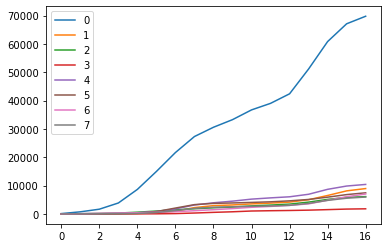

In [188]:
eva.bd_locales['fallecido'].iloc[:,:-1].groupby(km.labels_).sum().T.plot()

In [189]:
eva.rdos_glob['clasificac']['lqperi'].matriz_intersec_deb.mean(axis = 1)

array([0.05882353, 0.11764706, 0.08823529, 0.11029412, 0.06617647,
       0.09558824, 0.11764706, 0.125     ])

In [196]:
np.sqrt(eva.rdos_loc['clasificac']['regiones'][2]['indices'])

array([455.80901914, 747.84685827])

<AxesSubplot:>

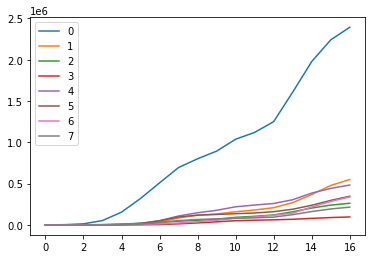

In [194]:
eva.bd_locales['clasificac'].iloc[:,:-1].groupby(km.labels_).sum().T.plot()